In [24]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns


In [25]:
PROCESSED_DATA_FILE = './Dataset/processed_vehicle_2.parquet'

In [26]:
df=pd.read_parquet(PROCESSED_DATA_FILE)
df.head()

,record_time,vehicle_state,charge_state,pack_voltage,pack_current,soc,max_cell_voltage,min_cell_voltage,max_temp,min_temp
0,2021-11-08 06:42:07,Vehicle Start,Not Charging,431.0,0.0,97,2.425,2.344,17,13
1,2021-11-08 06:42:17,Vehicle Start,Not Charging,431.0,0.0,97,2.425,2.345,17,13
2,2021-11-08 06:42:27,Vehicle Start,Not Charging,430.7,4.5,97,2.422,2.342,17,13
3,2021-11-08 06:42:37,Vehicle Start,Not Charging,430.5,5.6,97,2.422,2.342,17,13
4,2021-11-08 06:42:47,Vehicle Start,Not Charging,430.3,5.5,97,2.420,2.340,17,13


Loading data from './Dataset/processed_vehicle_2.parquet' for general analysis...

--- Plotting 1: A Day in the Life of the Bus (2022-02-15) ---


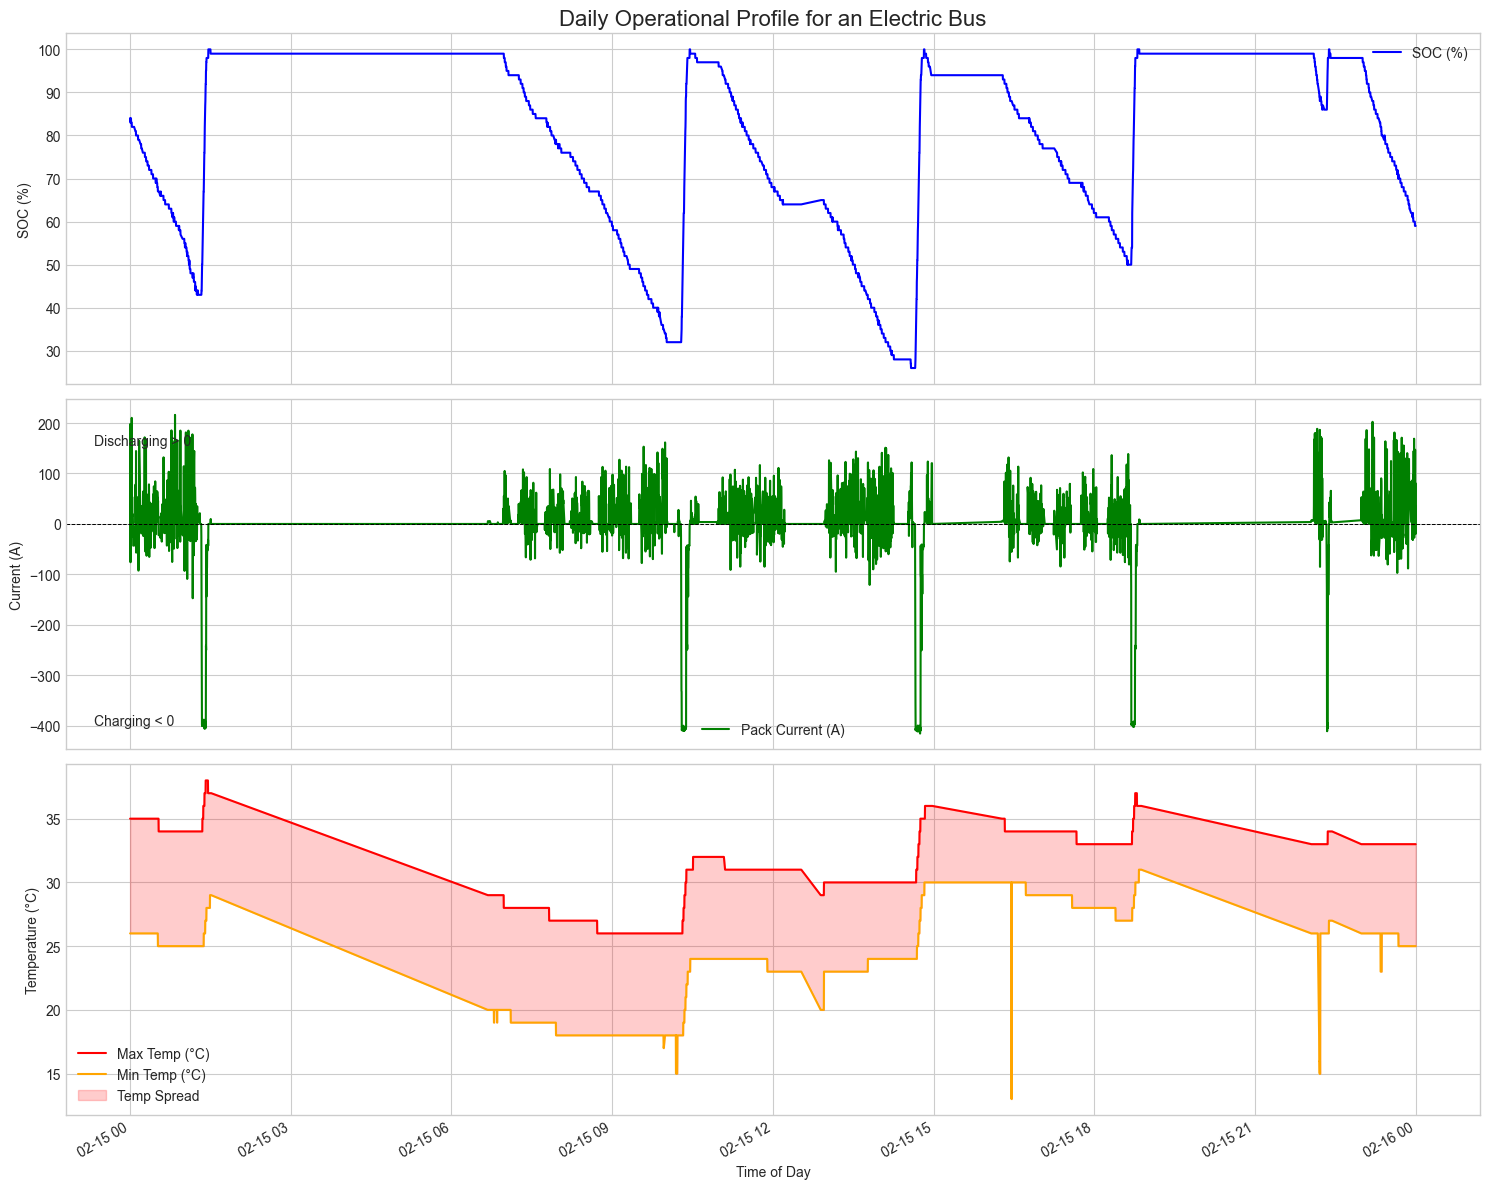


--- Plotting 2: Voltage vs. SOC Relationship ---


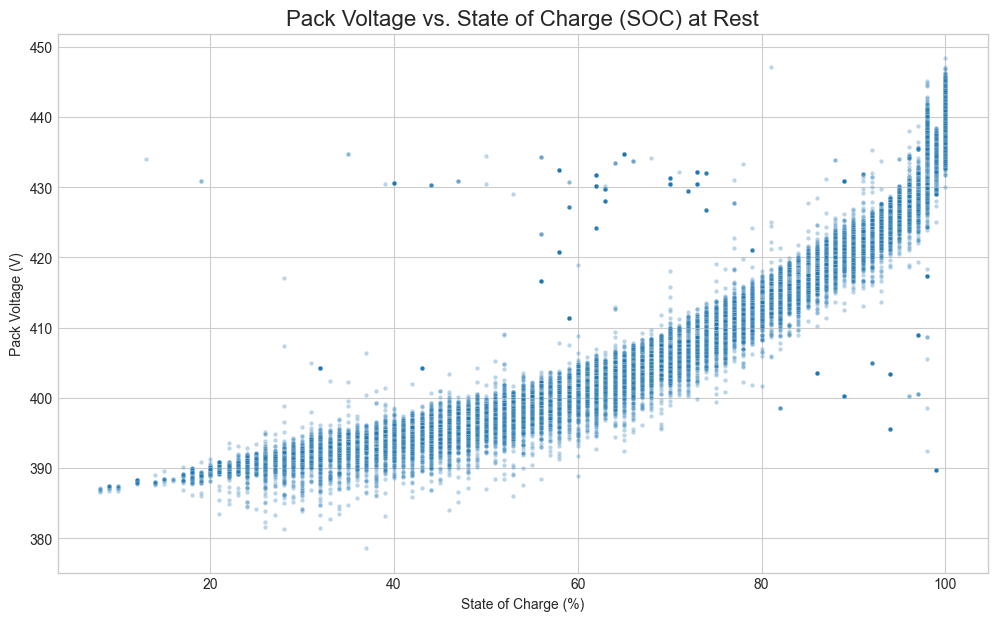


--- Plotting 3: Temperature Analysis ---


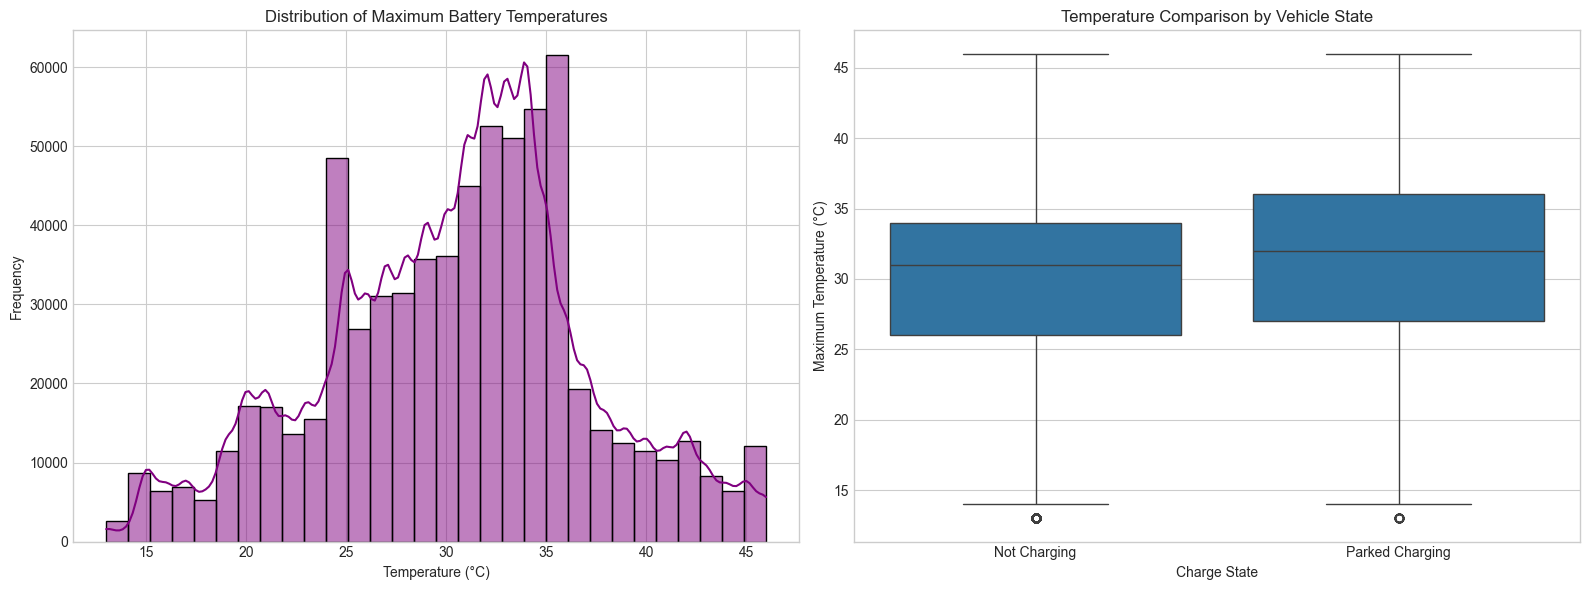


--- Plotting 4: Cell Imbalance Analysis ---


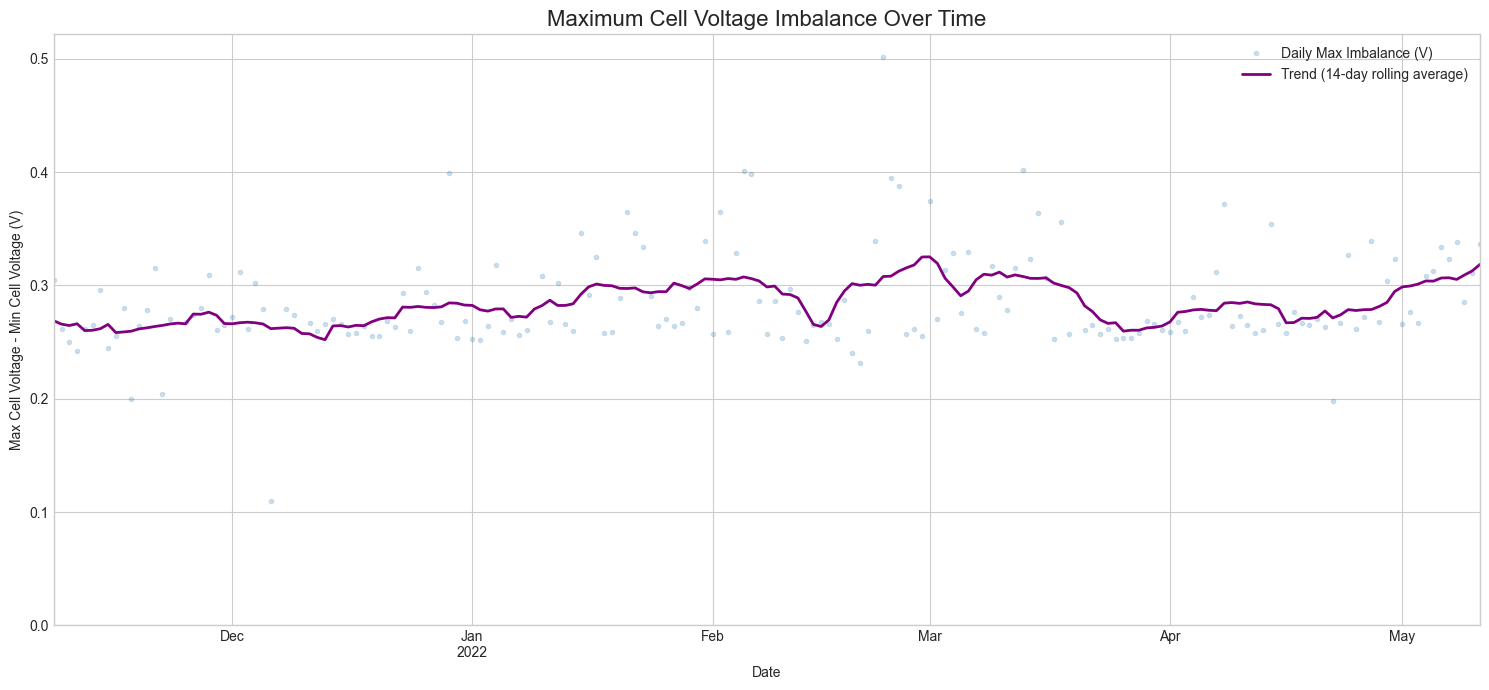

In [27]:

def perform_general_analysis(processed_file_path):
    """
    Performs general exploratory data analysis on the processed EV data.
    
    Args:
        processed_file_path (str): Path to the processed .parquet file.
    """
    print(f"Loading data from '{processed_file_path}' for general analysis...")
    df = pd.read_parquet(processed_file_path)


    day_df = df[df['record_time'].dt.date == pd.to_datetime('2022-02-15').date()].copy()

    if day_df.empty:
        print("Could not find data for the selected day (2022-02-15). Please choose another day.")
    else:
        print("\n--- Plotting 1: A Day in the Life of the Bus (2022-02-15) ---")
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        
        # Plot 1: SOC
        ax1.plot(day_df['record_time'], day_df['soc'], label='SOC (%)', color='b')
        ax1.set_ylabel('SOC (%)')
        ax1.set_title('Daily Operational Profile for an Electric Bus', fontsize=16)
        ax1.grid(True)
        ax1.legend()

        # Plot 2: Pack Current
        ax2.plot(day_df['record_time'], day_df['pack_current'], label='Pack Current (A)', color='g')
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.7)
        ax2.set_ylabel('Current (A)')
        ax2.text(0.02, 0.9, 'Discharging > 0', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
        ax2.text(0.02, 0.1, 'Charging < 0', transform=ax2.transAxes, fontsize=10, verticalalignment='top')
        ax2.grid(True)
        ax2.legend()

        # Plot 3: Temperature Range
        ax3.plot(day_df['record_time'], day_df['max_temp'], label='Max Temp (°C)', color='r')
        ax3.plot(day_df['record_time'], day_df['min_temp'], label='Min Temp (°C)', color='orange')
        ax3.fill_between(day_df['record_time'], day_df['min_temp'], day_df['max_temp'], color='r', alpha=0.2, label='Temp Spread')
        ax3.set_xlabel('Time of Day')
        ax3.set_ylabel('Temperature (°C)')
        ax3.grid(True)
        ax3.legend()
        
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()

    # --- 2. Voltage vs. SOC Relationship (OCV-SOC Curve) ---
    print("\n--- Plotting 2: Voltage vs. SOC Relationship ---")
    # To approximate Open-Circuit Voltage, we use data where the battery is at rest (current is near zero)
    rest_df = df[df['pack_current'].abs() < 1.0]
    
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x='soc', y='pack_voltage', data=rest_df, s=10, alpha=0.3)
    plt.title('Pack Voltage vs. State of Charge (SOC) at Rest', fontsize=16)
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Pack Voltage (V)')
    plt.grid(True)
    plt.show()

    # --- 3. Temperature Analysis ---
    print("\n--- Plotting 3: Temperature Analysis ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Histogram of maximum temperatures
    sns.histplot(df['max_temp'], bins=30, kde=True, ax=ax1, color='purple')
    ax1.set_title('Distribution of Maximum Battery Temperatures')
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Frequency')

    # Plot 2: Box plot comparing temperatures by charge state
    # We filter out 'Charging Complete' as it's a transient state
    temp_comp_df = df[df['charge_state'].isin(['Not Charging', 'Parked Charging'])]
    sns.boxplot(x='charge_state', y='max_temp', data=temp_comp_df, ax=ax2)
    ax2.set_title('Temperature Comparison by Vehicle State')
    ax2.set_xlabel('Charge State')
    ax2.set_ylabel('Maximum Temperature (°C)')
    
    plt.tight_layout()
    plt.show()

    # --- 4. Cell Imbalance Analysis ---
    print("\n--- Plotting 4: Cell Imbalance Analysis ---")
    df['cell_voltage_diff'] = df['max_cell_voltage'] - df['min_cell_voltage']
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Plot a rolling average of the maximum imbalance each day
    daily_max_imbalance = df.set_index('record_time')['cell_voltage_diff'].resample('D').max()
    daily_max_imbalance.plot(ax=ax, style='.', alpha=0.2, label='Daily Max Imbalance (V)')
    daily_max_imbalance.rolling(window=14, center=True, min_periods=5).mean().plot(ax=ax, color='purple', linewidth=2, label='Trend (14-day rolling average)')
    
    ax.set_title('Maximum Cell Voltage Imbalance Over Time', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Max Cell Voltage - Min Cell Voltage (V)')
    ax.set_ylim(bottom=0)
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    perform_general_analysis(PROCESSED_DATA_FILE)

Loading preprocessed data from './Dataset/processed_vehicle_2.parquet'...
Identifying charging segments...
Found 865 potential charging segments.


Estimating Capacity: 100%|██████████| 865/865 [00:01<00:00, 564.45it/s]



Successfully estimated capacity for 157 segments.

--- Raw Capacity Estimates Diagnosis ---
Statistics for ALL raw capacity estimates:
count    157.000000
mean      65.071334
std        2.208404
min       58.671296
25%       63.568889
50%       64.711111
75%       66.717279
max       72.361111
Name: estimated_capacity_ah, dtype: float64
----------------------------------------



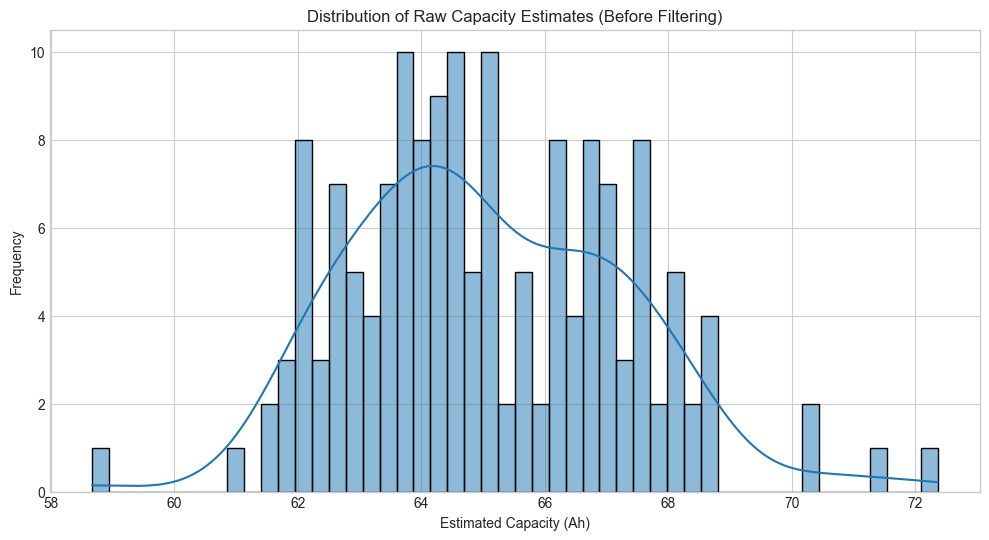

Applying initial physical filter: Capacity > 10 Ah and < 500 Ah
Removed 0 estimates based on the physical range.
Applying statistical filter: Removing values below 61.99 (5th percentile) and above 68.50 (95th percentile).
Removed 16 statistical outliers. 141 estimates remaining for SOH calculation.

Baseline Capacity (C_initial) estimated as: 66.88 Ah


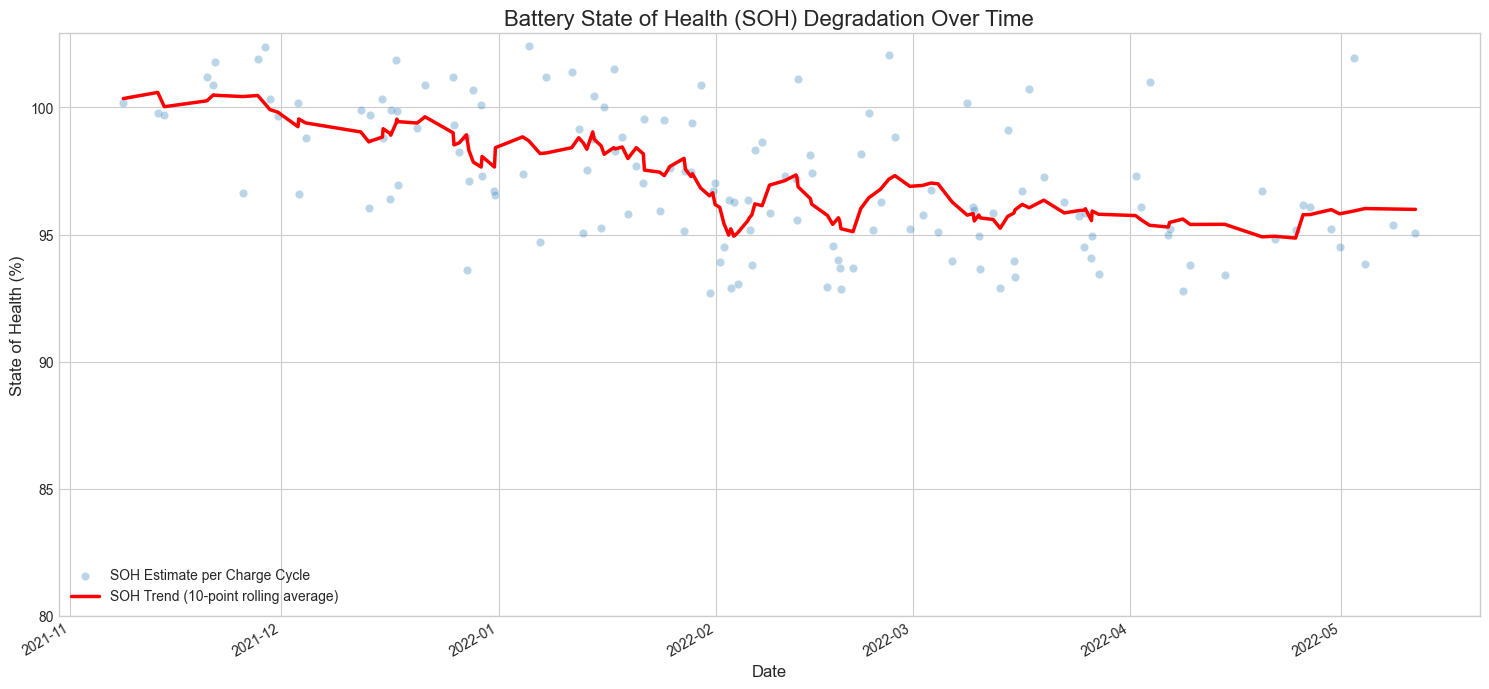

In [28]:
# --- Configuration ---
MIN_SOC_CHANGE_FOR_ESTIMATION = 10
MIN_DURATION_FOR_ESTIMATION_S = 600

MIN_CAPACITY_GUESS_AH = 10   
MAX_CAPACITY_GUESS_AH = 500

def estimate_soh_with_diagnostics(processed_file_path):
    """
    Estimates battery SOH with an initial diagnostic step to inspect raw capacity values.
    """
    print(f"Loading preprocessed data from '{processed_file_path}'...")
    df = pd.read_parquet(processed_file_path)

    print("Identifying charging segments...")
    charging_df = df[(df['charge_state'] == 'Parked Charging') & (df['pack_current'] < 0)].copy()

    if charging_df.empty:
        print("No 'Parked Charging' segments found.")
        return

    time_diff = charging_df['record_time'].diff().dt.total_seconds()
    charging_df['segment_id'] = (time_diff > 60).cumsum()
    print(f"Found {charging_df['segment_id'].nunique()} potential charging segments.")

    capacity_estimates = []
    grouped_segments = charging_df.groupby('segment_id')

    for segment_id, segment_df in tqdm(grouped_segments, desc="Estimating Capacity"):
        if len(segment_df) < 2:
            continue
            
        segment_df = segment_df.sort_values('record_time')
        delta_t_seconds = segment_df['record_time'].diff().dt.total_seconds()
        
        soc_start = segment_df['soc'].iloc[0]
        soc_end = segment_df['soc'].iloc[-1]
        time_start = segment_df['record_time'].iloc[0]
        duration_seconds = (segment_df['record_time'].iloc[-1] - time_start).total_seconds()
        
        delta_soc = soc_end - soc_start

        if delta_soc < MIN_SOC_CHANGE_FOR_ESTIMATION or duration_seconds < MIN_DURATION_FOR_ESTIMATION_S:
            continue
            
        avg_current = (segment_df['pack_current'] + segment_df['pack_current'].shift(-1)) / 2
        delta_charge_ah = -1 * np.sum(avg_current.iloc[:-1] * (delta_t_seconds.iloc[1:] / 3600.0))

        if delta_soc > 0:
            estimated_capacity = delta_charge_ah / (delta_soc / 100.0)
            capacity_estimates.append({
                'timestamp': time_start,
                'estimated_capacity_ah': estimated_capacity
            })

    if not capacity_estimates:
        print("Could not estimate capacity for any segment. Try adjusting filter parameters.")
        return

    capacity_df = pd.DataFrame(capacity_estimates)
    print(f"\nSuccessfully estimated capacity for {len(capacity_df)} segments.")
    
    # --- DIAGNOSTIC STEP: Inspect the raw capacity estimates before filtering ---
    print("\n--- Raw Capacity Estimates Diagnosis ---")
    print("Statistics for ALL raw capacity estimates:")
    print(capacity_df['estimated_capacity_ah'].describe())
    print("----------------------------------------\n")

    # Visualize the distribution of the raw estimates to understand the range
    plt.figure(figsize=(12, 6))
    sns.histplot(capacity_df['estimated_capacity_ah'], bins=50, kde=True)
    plt.title('Distribution of Raw Capacity Estimates (Before Filtering)')
    plt.xlabel('Estimated Capacity (Ah)')
    plt.ylabel('Frequency')
    plt.show()

    # Step 4: Filter Outliers (Now with better-informed values)
    print(f"Applying initial physical filter: Capacity > {MIN_CAPACITY_GUESS_AH} Ah and < {MAX_CAPACITY_GUESS_AH} Ah")
    initial_estimate_count = len(capacity_df)
    
    capacity_df_filtered = capacity_df[
        (capacity_df['estimated_capacity_ah'] > MIN_CAPACITY_GUESS_AH) & 
        (capacity_df['estimated_capacity_ah'] < MAX_CAPACITY_GUESS_AH)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    print(f"Removed {initial_estimate_count - len(capacity_df_filtered)} estimates based on the physical range.")
    
    # Check if we have any data left before applying the quantile filter
    if capacity_df_filtered.empty:
        print("Error: The initial physical filter removed all data. Please adjust MIN/MAX_CAPACITY_GUESS_AH.")
        return

    # Use quantiles to remove statistical outliers
    q_low = capacity_df_filtered['estimated_capacity_ah'].quantile(0.05)
    q_high = capacity_df_filtered['estimated_capacity_ah'].quantile(0.95)
    
    print(f"Applying statistical filter: Removing values below {q_low:.2f} (5th percentile) and above {q_high:.2f} (95th percentile).")
    
    final_count_before_quantile = len(capacity_df_filtered)
    capacity_df_filtered = capacity_df_filtered[
        (capacity_df_filtered['estimated_capacity_ah'] > q_low) & 
        (capacity_df_filtered['estimated_capacity_ah'] < q_high)
    ]
    
    print(f"Removed {final_count_before_quantile - len(capacity_df_filtered)} statistical outliers. {len(capacity_df_filtered)} estimates remaining for SOH calculation.")

    if capacity_df_filtered.empty:
        print("Error: The quantile filter removed all data. The data might be too sparse or noisy.")
        return

    # Step 5: Establish Initial Capacity and Calculate SOH
    first_month_start = capacity_df_filtered['timestamp'].min()
    first_month_end = first_month_start + pd.Timedelta(days=30)
    
    initial_capacity_estimates = capacity_df_filtered[capacity_df_filtered['timestamp'] <= first_month_end]
    
    if initial_capacity_estimates.empty:
        print("Not enough data in the first 30 days to establish a baseline. SOH calculation aborted.")
        return
        
    c_initial = initial_capacity_estimates['estimated_capacity_ah'].mean()
    print(f"\nBaseline Capacity (C_initial) estimated as: {c_initial:.2f} Ah")

    capacity_df_filtered['soh'] = (capacity_df_filtered['estimated_capacity_ah'] / c_initial) * 100

    # Step 6: Visualize the Results
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(15, 7))

    sns.scatterplot(x='timestamp', y='soh', data=capacity_df_filtered, ax=ax1, alpha=0.3, label='SOH Estimate per Charge Cycle')
    
    rolling_soh = capacity_df_filtered.set_index('timestamp')['soh'].rolling(window=10, center=True, min_periods=3).mean()
    rolling_soh.plot(ax=ax1, color='red', linewidth=2.5, label='SOH Trend (10-point rolling average)')

    ax1.set_title('Battery State of Health (SOH) Degradation Over Time', fontsize=16)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('State of Health (%)', fontsize=12)
    ax1.set_ylim(bottom=min(80, capacity_df_filtered['soh'].min() - 5))
    ax1.legend()
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    PROCESSED_DATA_FILE = './Dataset/processed_vehicle_2.parquet'
    estimate_soh_with_diagnostics(PROCESSED_DATA_FILE)

Loading preprocessed data from './Dataset/processed_vehicle_2.parquet'...
Identifying charging segments...

--- Cycle Count Analysis ---
Identified 865 distinct partial charging cycles.
These sum to a total of 396.90 Equivalent Full Cycles (EFCs) over the ~6 month period.
----------------------------



Estimating Capacity: 100%|██████████| 865/865 [00:01<00:00, 559.12it/s]


Plotting SOH degradation against Equivalent Full Cycles (EFC)...


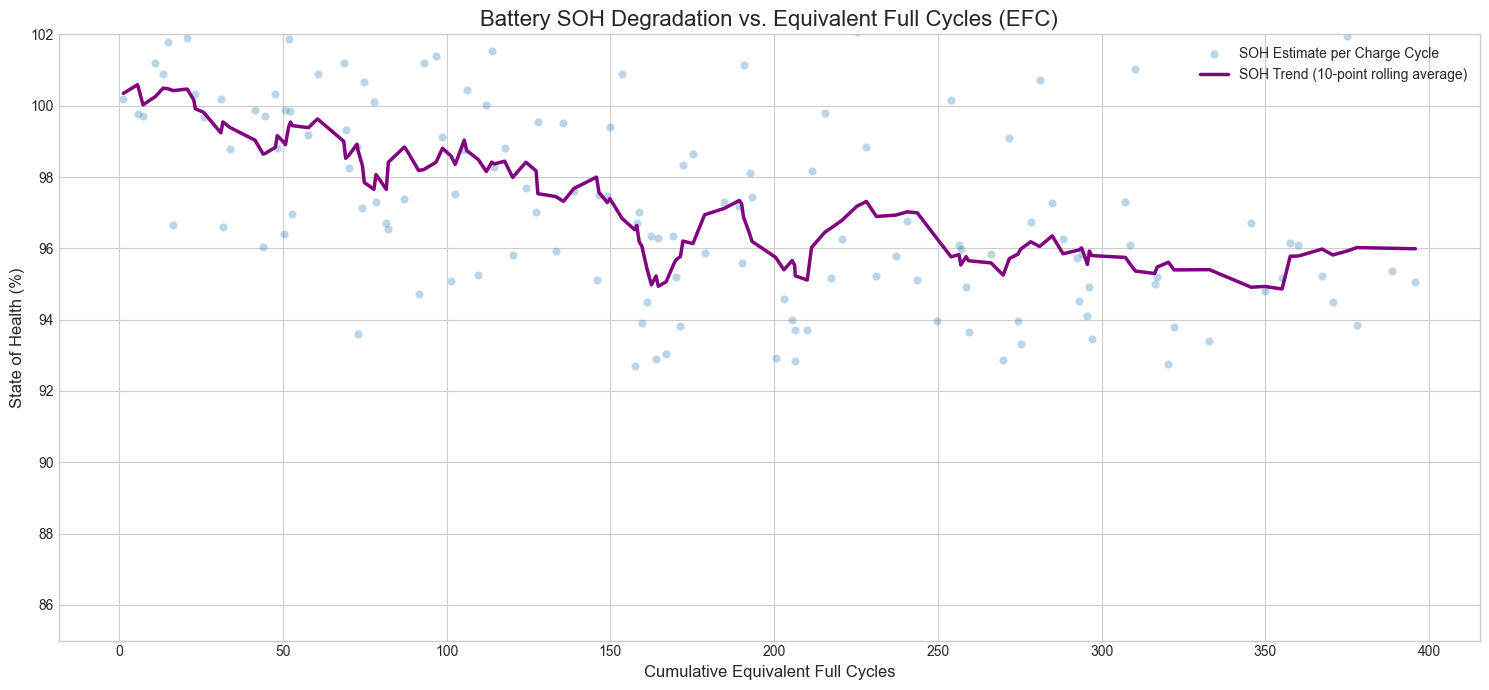

In [29]:
# --- Configuration ---
MIN_SOC_CHANGE_FOR_ESTIMATION = 10  # Minimum % of SOC change
MIN_DURATION_FOR_ESTIMATION_S = 600 # Minimum duration in seconds
MIN_CAPACITY_GUESS_AH = 50          # Adjusted based on our previous diagnosis
MAX_CAPACITY_GUESS_AH = 80          # Adjusted based on our previous diagnosis

def estimate_soh_vs_cycles(processed_file_path):
    """
    Estimates battery SOH and plots degradation against both time and cycle count.
    """
    print(f"Loading preprocessed data from '{processed_file_path}'...")
    df = pd.read_parquet(processed_file_path)

    print("Identifying charging segments...")
    charging_df = df[(df['charge_state'] == 'Parked Charging') & (df['pack_current'] < 0)].copy()

    if charging_df.empty:
        print("No 'Parked Charging' segments found.")
        return

    time_diff = charging_df['record_time'].diff().dt.total_seconds()
    charging_df['segment_id'] = (time_diff > 60).cumsum()
    
    # --- NEW: Calculate Equivalent Full Cycles (EFC) for each segment ---
    # EFC for a segment is the total change in SOC divided by 100.
    segment_soc_change = charging_df.groupby('segment_id')['soc'].agg(lambda x: x.iloc[-1] - x.iloc[0])
    segment_efc = segment_soc_change / 100.0
    
    # Calculate the cumulative EFC over time
    cumulative_efc_map = segment_efc.cumsum().to_dict()
    
    # Map this back to our original segment data
    charging_df['cumulative_efc'] = charging_df['segment_id'].map(cumulative_efc_map)

    # --- We can now count the number of partial cycles ---
    num_partial_cycles = charging_df['segment_id'].nunique()
    total_efc = cumulative_efc_map[max(cumulative_efc_map.keys())]
    
    print(f"\n--- Cycle Count Analysis ---")
    print(f"Identified {num_partial_cycles} distinct partial charging cycles.")
    print(f"These sum to a total of {total_efc:.2f} Equivalent Full Cycles (EFCs) over the ~6 month period.")
    print("----------------------------\n")

    capacity_estimates = []
    grouped_segments = charging_df.groupby('segment_id')

    for segment_id, segment_df in tqdm(grouped_segments, desc="Estimating Capacity"):
        if len(segment_df) < 2:
            continue
            
        segment_df = segment_df.sort_values('record_time')
        delta_t_seconds = segment_df['record_time'].diff().dt.total_seconds()
        
        soc_start = segment_df['soc'].iloc[0]
        soc_end = segment_df['soc'].iloc[-1]
        time_start = segment_df['record_time'].iloc[0]
        duration_seconds = (segment_df['record_time'].iloc[-1] - time_start).total_seconds()
        
        delta_soc = soc_end - soc_start

        if delta_soc < MIN_SOC_CHANGE_FOR_ESTIMATION or duration_seconds < MIN_DURATION_FOR_ESTIMATION_S:
            continue
            
        avg_current = (segment_df['pack_current'] + segment_df['pack_current'].shift(-1)) / 2
        delta_charge_ah = -1 * np.sum(avg_current.iloc[:-1] * (delta_t_seconds.iloc[1:] / 3600.0))

        if delta_soc > 0:
            estimated_capacity = delta_charge_ah / (delta_soc / 100.0)
            capacity_estimates.append({
                'timestamp': time_start,
                'estimated_capacity_ah': estimated_capacity,
                'cumulative_efc': segment_df['cumulative_efc'].iloc[0] # Get the EFC at the start of this segment
            })

    if not capacity_estimates:
        print("Could not estimate capacity for any segment.")
        return

    capacity_df = pd.DataFrame(capacity_estimates)
    
    # Filter Outliers
    capacity_df_filtered = capacity_df[
        (capacity_df['estimated_capacity_ah'] > MIN_CAPACITY_GUESS_AH) & 
        (capacity_df['estimated_capacity_ah'] < MAX_CAPACITY_GUESS_AH)
    ].copy()
    
    q_low = capacity_df_filtered['estimated_capacity_ah'].quantile(0.05)
    q_high = capacity_df_filtered['estimated_capacity_ah'].quantile(0.95)
    
    capacity_df_filtered = capacity_df_filtered[
        (capacity_df_filtered['estimated_capacity_ah'] > q_low) & 
        (capacity_df_filtered['estimated_capacity_ah'] < q_high)
    ]

    # Establish Initial Capacity and Calculate SOH
    first_month_start = capacity_df_filtered['timestamp'].min()
    first_month_end = first_month_start + pd.Timedelta(days=30)
    initial_capacity_estimates = capacity_df_filtered[capacity_df_filtered['timestamp'] <= first_month_end]
    
    if initial_capacity_estimates.empty:
        print("Not enough data in the first 30 days to establish a baseline.")
        return
        
    c_initial = initial_capacity_estimates['estimated_capacity_ah'].mean()
    capacity_df_filtered['soh'] = (capacity_df_filtered['estimated_capacity_ah'] / c_initial) * 100
    
    # --- PLOTTING SOH vs. CYCLES ---
    print("Plotting SOH degradation against Equivalent Full Cycles (EFC)...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot individual SOH estimates vs EFC
    sns.scatterplot(
        x='cumulative_efc', 
        y='soh', 
        data=capacity_df_filtered, 
        ax=ax,
        alpha=0.3,
        label='SOH Estimate per Charge Cycle'
    )
    
    # Plot a rolling average to see the trend
    # We need to sort by EFC before applying a rolling window
    soh_vs_efc = capacity_df_filtered.sort_values('cumulative_efc').set_index('cumulative_efc')
    rolling_soh = soh_vs_efc['soh'].rolling(window=10, center=True, min_periods=3).mean()
    rolling_soh.plot(ax=ax, color='purple', linewidth=2.5, label='SOH Trend (10-point rolling average)')

    ax.set_title('Battery SOH Degradation vs. Equivalent Full Cycles (EFC)', fontsize=16)
    ax.set_xlabel('Cumulative Equivalent Full Cycles', fontsize=12)
    ax.set_ylabel('State of Health (%)', fontsize=12)
    ax.set_ylim(85, 102) # Set y-axis for better view
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    PROCESSED_DATA_FILE = './Dataset/processed_vehicle_2.parquet'
    estimate_soh_vs_cycles(PROCESSED_DATA_FILE)

Loading data from './Dataset/processed_vehicle_2.parquet' for discontinuity analysis...
Scanning all charging segments for data gaps...


Analyzing Segments: 100%|██████████| 865/865 [00:02<00:00, 416.86it/s]



--- Discontinuity Analysis Summary ---
Total charging segments analyzed: 865
Number of segments with at least one gap: 111
Total number of data gaps found: 119

Gap Duration (seconds):
count    119.000000
mean      30.277311
std       13.209476
min       13.000000
25%       20.000000
50%       20.000000
75%       40.000000
max       60.000000
Name: gap_duration_s, dtype: float64

Current Change Across Gaps (Amps):
count    119.000000
mean      43.320168
std       69.880523
min        0.000000
25%        0.700000
50%       18.100000
75%       42.700000
max      367.300000
Name: current_change_across_gap, dtype: float64
------------------------------------


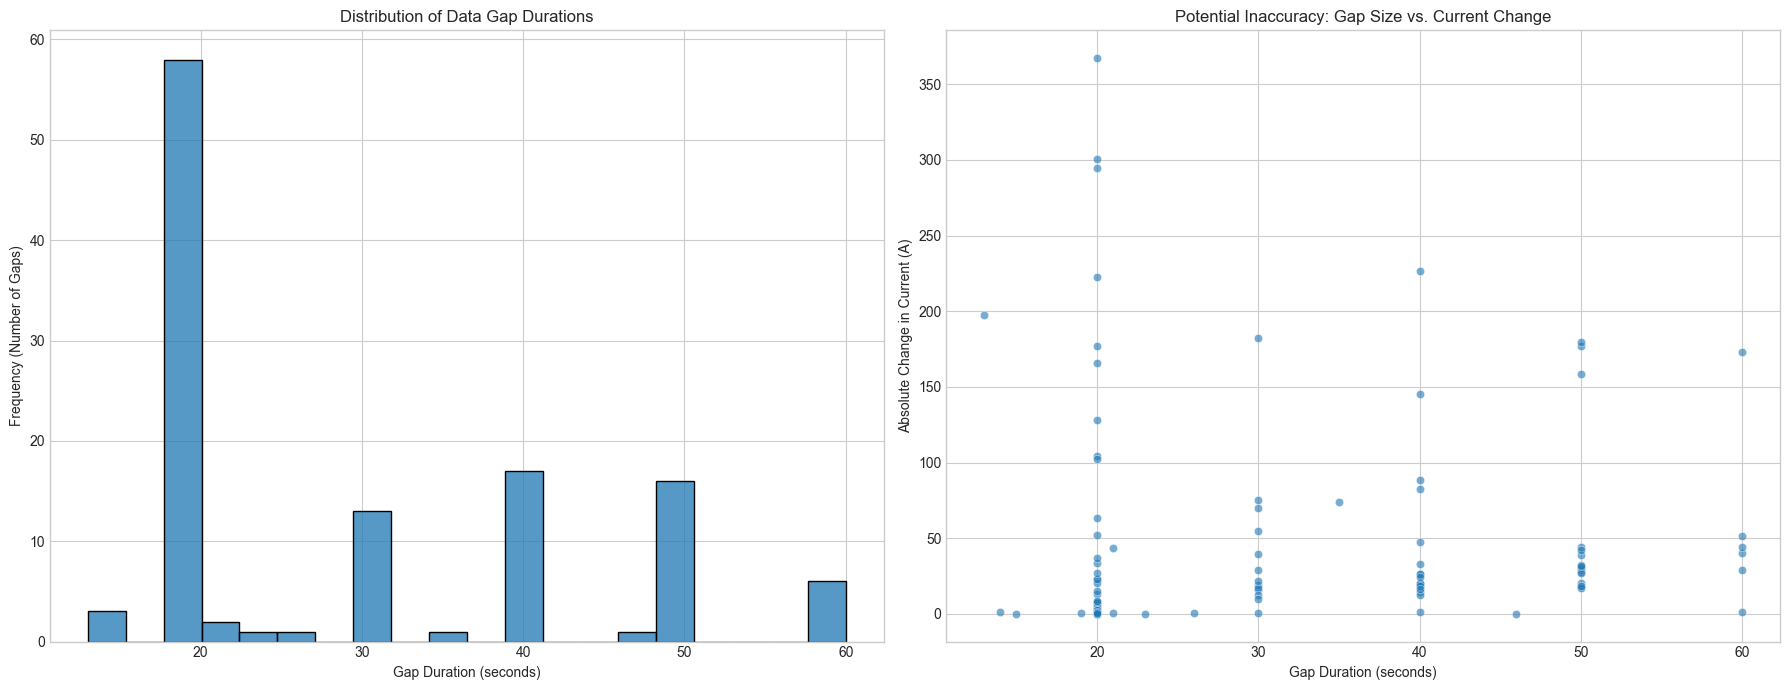

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration ---
GAP_THRESHOLD_S = 11 

def analyze_discontinuity(processed_file_path):
    """
    Analyzes data gaps during charging cycles to assess potential inaccuracies.
    (Corrected Version)
    """
    print(f"Loading data from '{processed_file_path}' for discontinuity analysis...")
    df = pd.read_parquet(processed_file_path)

    charging_df = df[(df['charge_state'] == 'Parked Charging') & (df['pack_current'] < 0)].copy()
    if charging_df.empty:
        print("No 'Parked Charging' segments found.")
        return

    time_diff = charging_df['record_time'].diff().dt.total_seconds()
    charging_df['segment_id'] = (time_diff > 60).cumsum()
    
    print("Scanning all charging segments for data gaps...")
    gaps_found = []
    
    grouped_segments = charging_df.groupby('segment_id')
    for segment_id, segment_df in tqdm(grouped_segments, desc="Analyzing Segments"):
        if len(segment_df) < 2:
            continue
        
        # Reset the index of the segment to be a simple 0, 1, 2...
        # This makes integer-based lookups much safer and easier.
        segment_df = segment_df.sort_values('record_time').reset_index(drop=True)
        segment_df['time_diff_s'] = segment_df['record_time'].diff().dt.total_seconds()
        
        # Find all rows where a gap occurred
        gap_rows = segment_df[segment_df['time_diff_s'] > GAP_THRESHOLD_S]
        
        # The index now corresponds to the row's integer position in segment_df
        for index, row in gap_rows.iterrows():
            
            # --- THE FIX ---
            # Now we can safely access the previous row using its integer position (index - 1)
            # because we reset the index above.
            previous_row = segment_df.iloc[index - 1]
            
            gaps_found.append({
                'segment_id': segment_id,
                'timestamp_after_gap': row['record_time'],
                'gap_duration_s': row['time_diff_s'],
                'current_before_gap': previous_row['pack_current'],
                'current_after_gap': row['pack_current']
            })

    if not gaps_found:
        print("\n--- Analysis Complete ---")
        print("Excellent! No significant data gaps were found in the charging segments.")
        return

    # --- Analysis and Visualization (This part remains the same) ---
    gaps_df = pd.DataFrame(gaps_found)
    gaps_df['current_change_across_gap'] = abs(gaps_df['current_after_gap'] - gaps_df['current_before_gap'])

    print("\n--- Discontinuity Analysis Summary ---")
    print(f"Total charging segments analyzed: {charging_df['segment_id'].nunique()}")
    print(f"Number of segments with at least one gap: {gaps_df['segment_id'].nunique()}")
    print(f"Total number of data gaps found: {len(gaps_df)}")
    print("\nGap Duration (seconds):")
    print(gaps_df['gap_duration_s'].describe())
    print("\nCurrent Change Across Gaps (Amps):")
    print(gaps_df['current_change_across_gap'].describe())
    print("------------------------------------")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    sns.histplot(gaps_df['gap_duration_s'], bins=20, ax=ax1, kde=False)
    ax1.set_title('Distribution of Data Gap Durations')
    ax1.set_xlabel('Gap Duration (seconds)')
    ax1.set_ylabel('Frequency (Number of Gaps)')

    sns.scatterplot(x='gap_duration_s', y='current_change_across_gap', data=gaps_df, ax=ax2, alpha=0.6)
    ax2.set_title('Potential Inaccuracy: Gap Size vs. Current Change')
    ax2.set_xlabel('Gap Duration (seconds)')
    ax2.set_ylabel('Absolute Change in Current (A)')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    PROCESSED_DATA_FILE = './Dataset/processed_vehicle_2.parquet'
    analyze_discontinuity(PROCESSED_DATA_FILE)

Loading preprocessed data from './Dataset/processed_vehicle_2.parquet'...
Identifying charging segments...
Found 874 potential charging segments using state-change logic.


Estimating Capacity: 100%|██████████| 874/874 [00:01<00:00, 621.80it/s]



Successfully estimated capacity for 160 segments.

--- Raw Capacity Estimates Diagnosis ---
Statistics for ALL raw capacity estimates:
count    160.000000
mean      64.904456
std        2.129664
min       58.671296
25%       63.461846
50%       64.613325
75%       66.549884
max       71.371261
Name: estimated_capacity_ah, dtype: float64
----------------------------------------



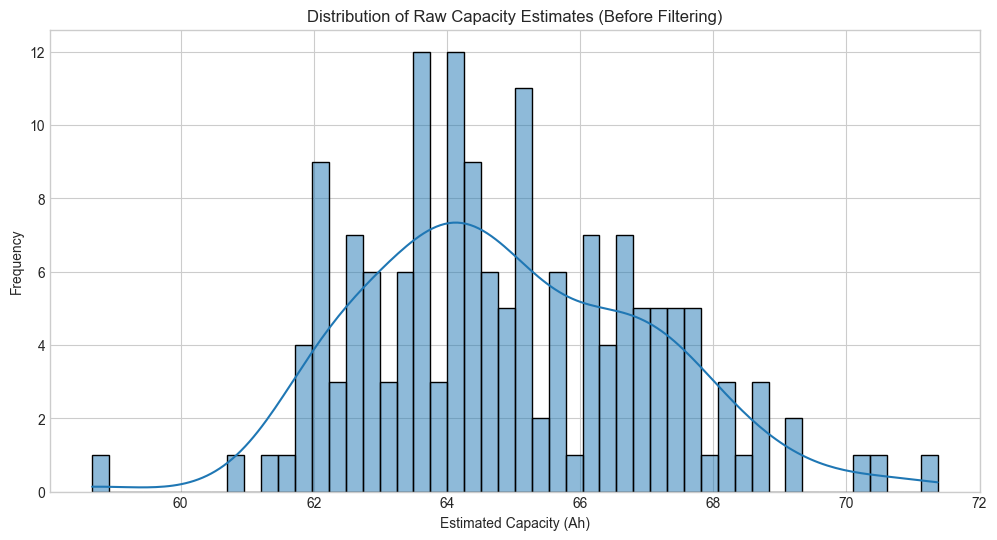

Applying initial physical filter: Capacity > 10 Ah and < 500 Ah
Removed 0 estimates based on the physical range.
Applying statistical filter: Removing values below 61.98 (5th percentile) and above 68.47 (95th percentile).
Removed 16 statistical outliers. 144 estimates remaining for SOH calculation.

Baseline Capacity (C_initial) estimated as: 66.68 Ah


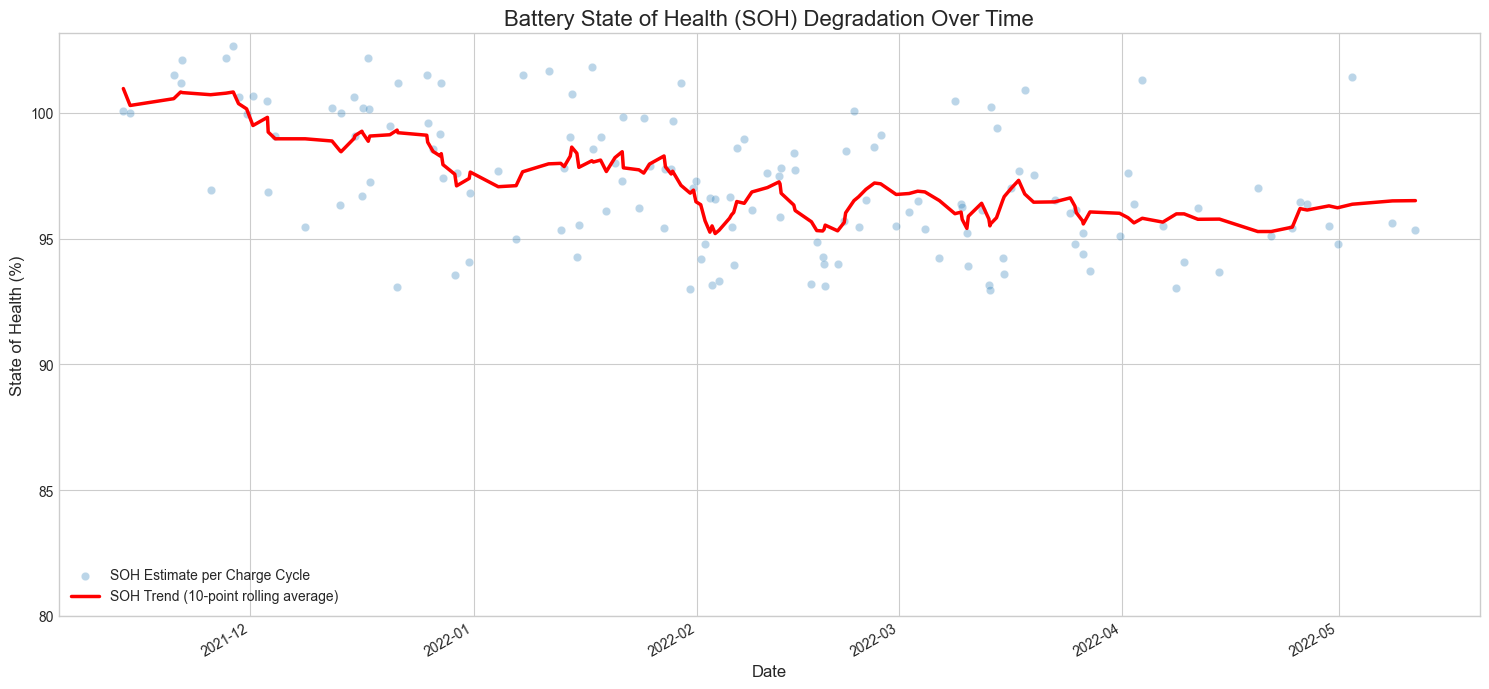

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration ---
MIN_SOC_CHANGE_FOR_ESTIMATION = 10
MIN_DURATION_FOR_ESTIMATION_S = 600

MIN_CAPACITY_GUESS_AH = 10   
MAX_CAPACITY_GUESS_AH = 500
charging_df=None

def estimate_soh_with_diagnostics(processed_file_path):
    global charging_df
    """
    Estimates battery SOH with a more robust segment identification logic.
    """
    print(f"Loading preprocessed data from '{processed_file_path}'...")
    df = pd.read_parquet(processed_file_path)

    print("Identifying charging segments...")
    # Filter for 'Parked Charging' rows, keeping the original index
    charging_df = df[(df['charge_state'] == 'Parked Charging') & (df['pack_current'] < 0)].copy()

    if charging_df.empty:
        print("No 'Parked Charging' segments with negative current found.")
        return

    # --- ROBUST SEGMENT IDENTIFICATION (The Changed Part) ---
    # The key is to check for non-consecutive rows from the original dataframe.
    # We can do this by looking at the dataframe's index. A new segment starts
    # if the difference between the indices of consecutive 'Parked Charging' rows
    # is greater than 1. This signifies a state change occurred in between.
    
    # Calculate the difference between consecutive indices in the filtered dataframe.
    index_diff = charging_df.index.to_series().diff()
    
    # A difference > 1 means there was an interruption (a different charge_state).
    # Use .cumsum() to assign a unique ID to each continuous charging block.
    charging_df['segment_id'] = (index_diff > 1).cumsum()
    # --- END OF CHANGE ---

    print(f"Found {charging_df['segment_id'].nunique()} potential charging segments using state-change logic.")

    capacity_estimates = []
    grouped_segments = charging_df.groupby('segment_id')

    for segment_id, segment_df in tqdm(grouped_segments, desc="Estimating Capacity"):
        if len(segment_df) < 2:
            continue
            
        segment_df = segment_df.sort_values('record_time')
        delta_t_seconds = segment_df['record_time'].diff().dt.total_seconds()
        
        soc_start = segment_df['soc'].iloc[0]
        soc_end = segment_df['soc'].iloc[-1]
        time_start = segment_df['record_time'].iloc[0]
        duration_seconds = (segment_df['record_time'].iloc[-1] - time_start).total_seconds()
        
        delta_soc = soc_end - soc_start

        if delta_soc < MIN_SOC_CHANGE_FOR_ESTIMATION or duration_seconds < MIN_DURATION_FOR_ESTIMATION_S:
            continue
            
        # Use trapezoidal rule for more accurate integration
        avg_current = (segment_df['pack_current'] + segment_df['pack_current'].shift(-1)) / 2
        # Sum up the charge (I*t) for each interval
        delta_charge_ah = -1 * np.sum(avg_current.iloc[:-1] * (delta_t_seconds.iloc[1:] / 3600.0))

        if delta_soc > 0:
            estimated_capacity = delta_charge_ah / (delta_soc / 100.0)
            capacity_estimates.append({
                'timestamp': time_start,
                'estimated_capacity_ah': estimated_capacity
            })

    if not capacity_estimates:
        print("Could not estimate capacity for any segment. Try adjusting filter parameters.")
        return

    capacity_df = pd.DataFrame(capacity_estimates)
    print(f"\nSuccessfully estimated capacity for {len(capacity_df)} segments.")
    
    # --- DIAGNOSTIC STEP: Inspect the raw capacity estimates before filtering ---
    print("\n--- Raw Capacity Estimates Diagnosis ---")
    print("Statistics for ALL raw capacity estimates:")
    print(capacity_df['estimated_capacity_ah'].describe())
    print("----------------------------------------\n")

    plt.figure(figsize=(12, 6))
    sns.histplot(capacity_df['estimated_capacity_ah'], bins=50, kde=True)
    plt.title('Distribution of Raw Capacity Estimates (Before Filtering)')
    plt.xlabel('Estimated Capacity (Ah)')
    plt.ylabel('Frequency')
    plt.show()

    # Step 4: Filter Outliers
    print(f"Applying initial physical filter: Capacity > {MIN_CAPACITY_GUESS_AH} Ah and < {MAX_CAPACITY_GUESS_AH} Ah")
    initial_estimate_count = len(capacity_df)
    
    capacity_df_filtered = capacity_df[
        (capacity_df['estimated_capacity_ah'] > MIN_CAPACITY_GUESS_AH) & 
        (capacity_df['estimated_capacity_ah'] < MAX_CAPACITY_GUESS_AH)
    ].copy()
    
    print(f"Removed {initial_estimate_count - len(capacity_df_filtered)} estimates based on the physical range.")
    
    if capacity_df_filtered.empty:
        print("Error: The initial physical filter removed all data. Please adjust MIN/MAX_CAPACITY_GUESS_AH.")
        return

    q_low = capacity_df_filtered['estimated_capacity_ah'].quantile(0.05)
    q_high = capacity_df_filtered['estimated_capacity_ah'].quantile(0.95)
    
    print(f"Applying statistical filter: Removing values below {q_low:.2f} (5th percentile) and above {q_high:.2f} (95th percentile).")
    
    final_count_before_quantile = len(capacity_df_filtered)
    capacity_df_filtered = capacity_df_filtered[
        (capacity_df_filtered['estimated_capacity_ah'] > q_low) & 
        (capacity_df_filtered['estimated_capacity_ah'] < q_high)
    ]
    
    print(f"Removed {final_count_before_quantile - len(capacity_df_filtered)} statistical outliers. {len(capacity_df_filtered)} estimates remaining for SOH calculation.")

    if capacity_df_filtered.empty:
        print("Error: The quantile filter removed all data. The data might be too sparse or noisy.")
        return

    # Step 5: Establish Initial Capacity and Calculate SOH
    first_month_start = capacity_df_filtered['timestamp'].min()
    first_month_end = first_month_start + pd.Timedelta(days=30)
    
    initial_capacity_estimates = capacity_df_filtered[capacity_df_filtered['timestamp'] <= first_month_end]
    
    if initial_capacity_estimates.empty:
        print("Not enough data in the first 30 days to establish a baseline. SOH calculation aborted.")
        return
        
    c_initial = initial_capacity_estimates['estimated_capacity_ah'].mean()
    print(f"\nBaseline Capacity (C_initial) estimated as: {c_initial:.2f} Ah")

    capacity_df_filtered['soh'] = (capacity_df_filtered['estimated_capacity_ah'] / c_initial) * 100

    # Step 6: Visualize the Results
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(15, 7))

    sns.scatterplot(x='timestamp', y='soh', data=capacity_df_filtered, ax=ax1, alpha=0.3, label='SOH Estimate per Charge Cycle')
    
    rolling_soh = capacity_df_filtered.set_index('timestamp')['soh'].rolling(window=10, center=True, min_periods=3).mean()
    rolling_soh.plot(ax=ax1, color='red', linewidth=2.5, label='SOH Trend (10-point rolling average)')

    ax1.set_title('Battery State of Health (SOH) Degradation Over Time', fontsize=16)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('State of Health (%)', fontsize=12)
    ax1.set_ylim(bottom=min(80, capacity_df_filtered['soh'].min() - 5))
    ax1.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Ensure this path points to your preprocessed parquet file
    PROCESSED_DATA_FILE = './Dataset/processed_vehicle_2.parquet'
    estimate_soh_with_diagnostics(PROCESSED_DATA_FILE)

In [32]:
charging_df

,record_time,vehicle_state,charge_state,pack_voltage,pack_current,soc,max_cell_voltage,min_cell_voltage,max_temp,min_temp,segment_id
1001,2021-11-08 09:48:07,Engine Off,Parked Charging,397.1,-36.4,41,2.217,2.192,18,13,0
1002,2021-11-08 09:48:17,Engine Off,Parked Charging,401.8,-36.4,41,2.247,2.208,18,13,0
1003,2021-11-08 09:48:27,Engine Off,Parked Charging,406.8,-169.7,42,2.277,2.241,18,13,0
1004,2021-11-08 09:48:37,Engine Off,Parked Charging,423.4,-408.9,43,2.389,2.327,18,13,0
1005,2021-11-08 09:48:47,Engine Off,Parked Charging,426.6,-409.1,44,2.409,2.347,18,13,0
...,...,...,...,...,...,...,...,...,...,...,...
686294,2022-05-11 21:28:12,Engine Off,Parked Charging,440.4,-50.2,98,2.601,2.386,44,31,873
686295,2022-05-11 21:28:22,Engine Off,Parked Charging,440.1,-50.2,98,2.600,2.382,44,31,873
686296,2022-05-11 21:28:32,Engine Off,Parked Charging,440.3,-42.1,98,2.610,2.384,44,31,873
686297,2022-05-11 21:28:42,Engine Off,Parked Charging,440.8,-42.1,98,2.623,2.384,44,31,873


In [39]:
charging_df[100:150]

,record_time,vehicle_state,charge_state,pack_voltage,pack_current,soc,max_cell_voltage,min_cell_voltage,max_temp,min_temp,segment_id
2083,2021-11-08 12:52:57,Engine Off,Parked Charging,443.7,-43.1,98,2.580,2.395,31,24,1
2084,2021-11-08 12:53:07,Engine Off,Parked Charging,442.6,-51.2,98,2.576,2.394,31,24,1
2085,2021-11-08 12:53:17,Engine Off,Parked Charging,442.6,-51.3,98,2.586,2.392,31,25,1
2086,2021-11-08 12:53:27,Engine Off,Parked Charging,442.9,-51.2,98,2.600,2.393,31,25,1
2087,2021-11-08 12:53:37,Engine Off,Parked Charging,442.8,-43.1,98,2.603,2.391,31,25,1
2088,2021-11-08 12:53:47,Engine Off,Parked Charging,443.0,-43.1,98,2.609,2.391,31,25,1
2089,2021-11-08 12:53:57,Engine Off,Parked Charging,443.4,-43.1,98,2.620,2.392,31,25,1
2090,2021-11-08 12:54:07,Engine Off,Parked Charging,444.0,-43.1,98,2.634,2.392,31,25,1
2091,2021-11-08 12:54:17,Engine Off,Parked Charging,444.6,-43.1,98,2.645,2.395,31,25,1
2092,2021-11-08 12:54:27,Engine Off,Parked Charging,442.4,-43.1,98,2.613,2.382,31,25,1
